# **09.1 Cross Validation and Hyperparameter Optimisation RandomForestRegressor**

## Objectives

* Apply appropriate ML methods (regression/classification/clustering). Evaluate with relevant metrics. Compare approaches
* RandomForestRegressor

## Inputs

housing_cleaned-geo.csv

## Outputs

* RandomForestRegressor_set.csv
* RandomForestRegressor_model.pkl


---

# Baseline model

Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.model_selection import GridSearchCV


In [2]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned-geo.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction                   7248 non-null   object 
 1   price                         7248 non-null   float64
 2   transfer_date                 7248 non-null   object 
 3   postcode                      7248 non-null   object 
 4   property_type                 7248 non-null   object 
 5   new_build                     7248 non-null   float64
 6   tenure                        7248 non-null   object 
 7   PAON                          7248 non-null   object 
 8   SAON                          371 non-null    object 
 9   Street                        7219 non-null   object 
 10  Locality                      3020 non-null   object 
 11  town_city                     7248 non-null   object 
 12  district                      7248 non-null   object 
 13  cou

---

The ruc21 values refer to the Rural Urban Classification (RUC) codes which categorize each area as urban or rural based on population and settlement characteristics. Examples from your data include UNI, RUN1, RSNI, UF1, etc.

- UN1: Urban city and town
- RLN1: Rural town and fringe
- RSN1: Rural village
- UF1: Urban major conurbation
- RLF1: Rural hamlet and isolated dwellings
- RSF1: Rural hamlet and isolated dwellings in a sparse setting

In [4]:
df['ruc21'].value_counts()

ruc21
UN1     5888
RLN1     622
RSN1     469
UF1      131
RLF1      70
RSF1      68
Name: count, dtype: int64

In [5]:
# convert to datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]

In [6]:
# set model features

# Calculate distance to nearest retail shopping centre
# Using distance in OSGB36 / British National Grid (metres)
# Centre points (OSGB36 / British National Grid, metres)
CENTRES_OSGB = {
    'bhm': (406000, 286000),  # Birmingham city centre
    'cov': (433000, 279000),  # Coventry city centre
    'lei': (458500, 306000),  # Leicester city centre
    'not': (457119, 340206),  # Nottingham (Old Market Sq vicinity)
    'der': (435187, 336492),  # Derby (near Council House)
    'sto': (388468, 347224),  # Stoke-on-Trent (Hanley)
    'wol': (386523, 298603),  # Wolverhampton (Queen Sq)
    'sol': (414438, 279717),  # Solihull (Touchwood area)
}

# distances (km) for each centre and minimum distance
for key, (E0, N0) in CENTRES_OSGB.items():
    df[f'dist_{key}_km'] = np.hypot(df['oseast1m'] - E0, df['osnrth1m'] - N0) / 1000.0
df['min_dist_to_retail_centre_km'] = df[['dist_bhm_km', 'dist_cov_km', 'dist_lei_km', 'dist_not_km', 'dist_der_km', 'dist_sto_km', 'dist_wol_km', 'dist_sol_km']].min(axis=1)
# drop the individual distance columns
df = df.drop(columns=[f'dist_{key}_km' for key in CENTRES_OSGB.keys()])

num_feats   = ['log_total_floor_area','IMD_Rank','oseast1m','osnrth1m','min_dist_to_retail_centre_km','energy_band_num']
bin_feats   = ['new_build','is_leasehold']  # passthrough as 0/1
cat_feats   = ['property_type','ruc21']  # one-hot encode

# Control category order to set baselines via drop='first'
ptype_order = ['D','S','T','F']  # baseline becomes 'D' (Detached)
ruc21_order = ['UN1','UF1','RLN1','RSN1','RLF1','RSF1']  # baseline becomes UN1 (Urban city and town)

# Build the ColumnTransformer (code supported by Copilot)
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order, ruc21_order],
                              handle_unknown='ignore'),
         cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
)

# End-to-end pipeline
pipeline = Pipeline([
    ('pre', pre),
    ('model', RandomForestRegressor(random_state=101)) 
])

X = df[num_feats + cat_feats + bin_feats]
y = df['log_price']  # log price to reduce skew

# Test using the most recent 20% of the data as the test set
# Use a sorted split based on date
df = df.sort_values(by='transfer_date').reset_index(drop=True)
# split index at 80%
split_index = int(len(df) * 0.8)
print(f"Split index: {split_index}, Total records: {len(df)}")
print(f"Date at split index: {df.iloc[split_index]['transfer_date']}")

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# separate target variable
y_train = train_df['log_price']
y_test = test_df['log_price']
X_train = train_df.drop(columns=['log_price'])
X_test = test_df.drop(columns=['log_price'])

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)


Split index: 5667, Total records: 7084
Date at split index: 2025-08-01 00:00:00
* Train set: (5667, 51) (5667,) 
* Test set: (1417, 51) (1417,)


### Note:
- The following feature_importance_tree_based_models custom function was provided by the Code Institute for their Data Analysis with AI course.

In [9]:

param_grid = [{
    'model__n_estimators': [100,50,140],
    'model__max_depth': [None,4, 15],
    'model__min_samples_split': [2,50],
    'model__min_samples_leaf': [1,50],
    'model__max_leaf_nodes': [None,50],
}]


In [10]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    cv=3,  # 3-fold cross-validation
                    n_jobs=1,
                    verbose=3,  # print the score from every cross-validation
                    scoring='r2')

In [11]:
# run the grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END model__max_depth=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.677 total time=   8.2s
[CV 2/3] END model__max_depth=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.686 total time=   7.7s
[CV 3/3] END model__max_depth=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.723 total time=   7.4s
[CV 1/3] END model__max_depth=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50;, score=0.675 total time=   3.7s
[CV 2/3] END model__max_depth=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50;, score=0.680 total time=   3.8s
[CV 3/3] END model__max_depth=None, model__max_leaf_nodes=No

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['log_total_floor_area',
                                                                          'IMD_Rank',
                                                                          'oseast1m',
                                                                          'osnrth1m',
                                                                          'min_dist_to_retail_centre_km',
                                                                          'energy_band_num']),
                                                                        ('cat',
                                                                         OneHotEncoder(categories=[['D',
                                                                                                    'S',
                                                                                                    'T',
                                                                                                    'F'],
                                                                                                   ['UN1',
                                                                                                    'UF1',
                                                                                                    'RLN1',
                                                                                                    'RSN1',
                                                                                                    'RLF1',
                                                                                                    'RSF1']],
                                                                                       drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['property_type',
                                                                          'ruc21']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['new_build',
                                                                          'is_leasehold'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=101))]),
             n_jobs=1,
             param_grid=[{'model__max_depth': [None, 4, 15],
                          'model__max_leaf_nodes': [None, 50],
                          'model__min_samples_leaf': [1, 50],
                          'model__min_samples_split': [2, 50],
                          'model__n_estimators': [100, 50, 140]}],
             scoring='r2', verbose=3)

In [12]:
grid.cv_results_

{'mean_fit_time': array([ 7.82214332,  4.03247563, 20.04221177,  6.97877208,  3.36995784,
         8.88252934,  4.11450116,  2.2579747 ,  5.97538718,  4.67589227,
         2.33404215,  6.39304328,  6.41333612,  3.12973142,  6.97426629,
         4.96396311,  2.65233469,  6.98941445,  3.52425806,  1.901263  ,
         4.992004  ,  3.5707225 ,  1.8728296 ,  5.08407466,  3.32920726,
         1.60086489,  4.63753136,  2.18014971,  1.0077951 ,  2.92283416,
         1.92227435,  0.99224099,  2.7294414 ,  2.57409167,  1.14558864,
         4.42951711,  3.4982961 ,  1.7650001 ,  4.53472527,  4.01893004,
         1.68968272,  4.69084708,  3.30579551,  1.57745902,  4.6423436 ,
         3.12833301,  1.70823773,  5.45493396, 11.65882413,  4.42234588,
        14.51399128,  4.71404473,  2.51418678,  6.55816253,  2.53628778,
         1.22250271,  3.90074682,  2.73312696,  1.39926767,  4.46586657,
         7.36564906,  3.17644493,  7.09305048,  5.53508155,  2.58676211,
         7.42203108,  3.77492968, 

In [13]:
(pd.DataFrame(grid.cv_results_)
.sort_values(by='mean_test_score',ascending=False)
.filter(['params','mean_test_score'])
.values
 )

array([[{'model__max_depth': 15, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 140},
        0.6978577732692607],
       [{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 140},
        0.6973293282511493],
       [{'model__max_depth': 15, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100},
        0.6961500759781308],
       [{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100},
        0.6952972698550219],
       [{'model__max_depth': 15, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50},
        0.6922624168403751],
       [{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samp

In [14]:
grid.best_params_

{'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [15]:
pipeline = grid.best_estimator_
pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_total_floor_area',
                                                   'IMD_Rank', 'oseast1m',
                                                   'osnrth1m',
                                                   'min_dist_to_retail_centre_km',
                                                   'energy_band_num']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[['D',
                                                                             'S',
                                                                             'T',
                                                                             'F'],
                                                                            ['UN1',
                                                                             'UF1',
                                                                             'RLN1',
                                                                             'RSN1',
                                                                             'RLF1',
                                                                             'RSF1']],
                                                                drop='first',
                                                                handle_unknown='ignore'),
                                                  ['property_type', 'ruc21']),
                                                 ('bin', 'passthrough',
                                                  ['new_build',
                                                   'is_leasehold'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, n_estimators=140,
                                       random_state=101))])

In [16]:
def feature_importance_tree_based_models(model, columns):
  """
  Gets the model and the columns used to train the model
  - We use the model.feature_importances_ and columns to make a
  DataFrame that shows the importance of each feature
  - Next, we print the feature name and its relative importance order,
  followed by a barplot indicating the importance

  """

  # create DataFrame to display feature importance
  df_feature_importance = (pd.DataFrame(data={
      'Features': columns,
      'Importance': model.feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

  best_features = df_feature_importance['Features'].to_list()

  # Most important features statement and plot
  print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

  df_feature_importance.plot(kind='bar',x='Features',y='Importance')
  plt.show()


def get_feature_names_from_preprocessor(preprocessor):
    """Return feature names for each transformer within a fitted ColumnTransformer."""
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder' or transformer == 'drop':
            continue
        if transformer == 'passthrough':
            feature_names.extend(columns)
            continue
        fitted_transformer = transformer
        # Pipelines expose the final estimator through steps[-1]
        if hasattr(transformer, 'steps') and len(transformer.steps) > 0:
            fitted_transformer = transformer.steps[-1][1]
        if hasattr(fitted_transformer, 'get_feature_names_out'):
            try:
                names = fitted_transformer.get_feature_names_out(columns)
            except TypeError:
                names = fitted_transformer.get_feature_names_out()
        else:
            names = columns
        feature_names.extend(list(names))
    return feature_names

* These are the 16 most important features in descending order. The model was trained on them: 
['log_total_floor_area', 'IMD_Rank', 'osnrth1m', 'oseast1m', 'min_dist_to_retail_centre_km', 'property_type_T', 'property_type_F', 'energy_band_num', 'property_type_S', 'ruc21_RSN1', 'new_build', 'ruc21_RLN1', 'ruc21_RSF1', 'ruc21_UF1', 'ruc21_RLF1', 'is_leasehold']


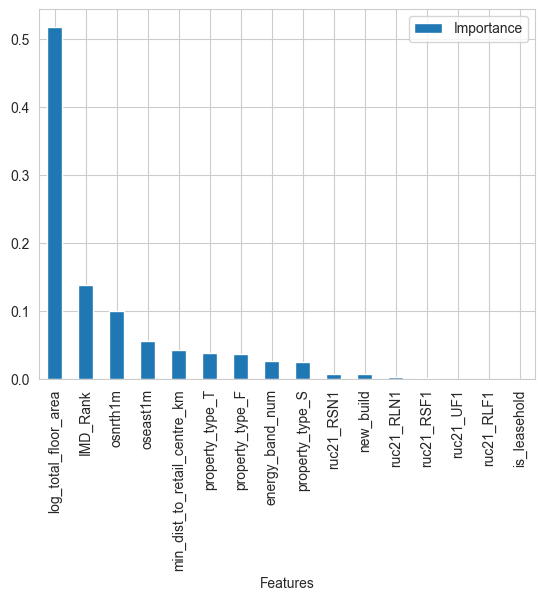

In [17]:
feature_names = get_feature_names_from_preprocessor(pipeline['pre'])
feature_importance_tree_based_models(model=pipeline['model'],
                                     columns=feature_names)

# Evaluate the model

In [18]:
# import regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
# we will use numpy to calculate RMSE based on MSE (mean_squared_error)
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test,pipeline):
  """
  # Gets train/test sets and pipeline and evaluates the performance
  - for each set (train and test) call regression_evaluation()
  which will evaluate the pipeline performance
  """

  print("Model Evaluation \n")
  print("* Train Set")
  regression_evaluation(X_train,y_train,pipeline)
  print("* Test Set")
  regression_evaluation(X_test,y_test,pipeline)



def regression_evaluation(X,y,pipeline):
  """
  # Gets features and target (either from train or test set) and pipeline
  - it predicts using the pipeline and the features
  - calculates performance metrics comparing the prediction to the target
  """
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  """
  # Gets Train and Test set (features and target), pipeline, and adjust dots transparency 
  at scatter plot
  - It predicts on train and test set
  - It creates Actual vs Prediction scatterplots, for train and test set
  - It draws a red diagonal line. In theory, a good regressor should predict
  close to the actual, meaning the dot should be close to the diagonal red line
  The closer the dots are to the line, the better

  """
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.949
Mean Absolute Error: 0.076
Mean Squared Error: 0.01
Root Mean Squared Error: 0.1


* Test Set
R2 Score: 0.77
Mean Absolute Error: 0.161
Mean Squared Error: 0.049
Root Mean Squared Error: 0.22




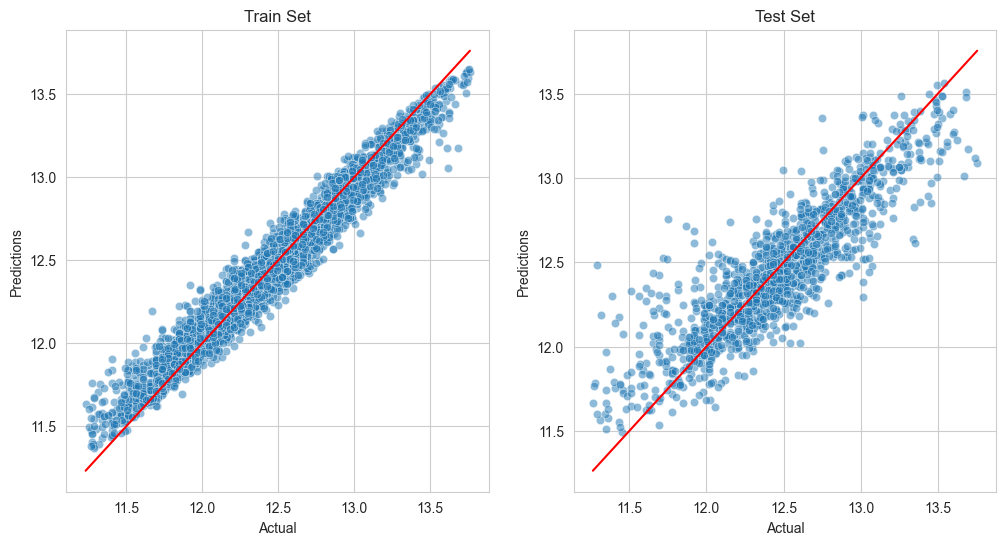

In [19]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

In [20]:
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


The train set Mean Absolute Error in GBP: 21,247
The test  set Mean Absolute Error in GBP: 44,860


* Note the R2 for train set is good 0.95 with a Mean Absolute Error £19,803. However, for test set the R2 is far less, R2 0.71. The MAE for the test set is far larger at £52,389. This may be a sign of overfitting. This is reinforced by the the actual vs predictions plots where we can see that the predictions are close to the actual prices for the train set compared to the test set.


In [21]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Gets train/test sets and pipeline and evaluates the performance
    for each set (train and test) by calling regression_evaluation()
    which will evaluate the pipeline performance.

    Parameters:
    - X_train: The input features of the training set.
    - y_train: The target values of the training set.
    - X_test: The input features of the test set.
    - y_test: The target values of the test set.
    - pipeline: The regression pipeline to evaluate.

    Returns:
    None
    """

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    
    Args:
        X (array-like): The input features.
        y (array-like): The target values.
        pipeline (object): The trained pipeline for regression.
    
    Returns:
        None
    
    Prints the following performance metrics comparing the prediction to the target:
    - R2 Score
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
    """
    prediction = pipeline.predict(X)
    print("R2 Score:", r2_score(y, prediction).round(3))
    print("Mean Absolute Error:", mean_absolute_error(y, prediction).round(3))
    print("Mean Squared Error:", mean_squared_error(y, prediction).round(3))
    print(
        "Root Mean Squared Error:", np.sqrt(mean_squared_error(y, prediction)).round(3)
    )
    print("\n")


Regression Model Performance 
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.949
Mean Absolute Error: 0.076
Mean Squared Error: 0.01
Root Mean Squared Error: 0.1


* Test Set
R2 Score: 0.77
Mean Absolute Error: 0.161
Mean Squared Error: 0.049
Root Mean Squared Error: 0.22


The train set Mean Absolute Error in GBP: 21,247
The test  set Mean Absolute Error in GBP: 44,860


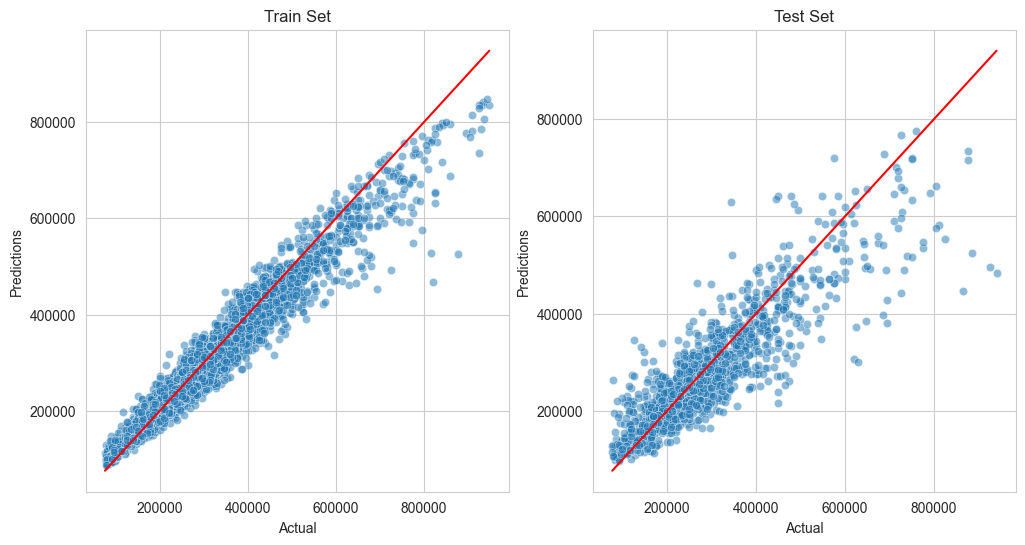

In [22]:
print("Regression Model Performance \nNote the MAE and MSE are in log(GBP) not GBP")
regression_performance(X_train, y_train, X_test, y_test, pipeline)

alpha_scatter=0.5
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.scatterplot(x=y_train_gbp, y=y_pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train_gbp, y=y_train_gbp, color="red", ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test_gbp, y=y_test_gbp, color="red", ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.show()


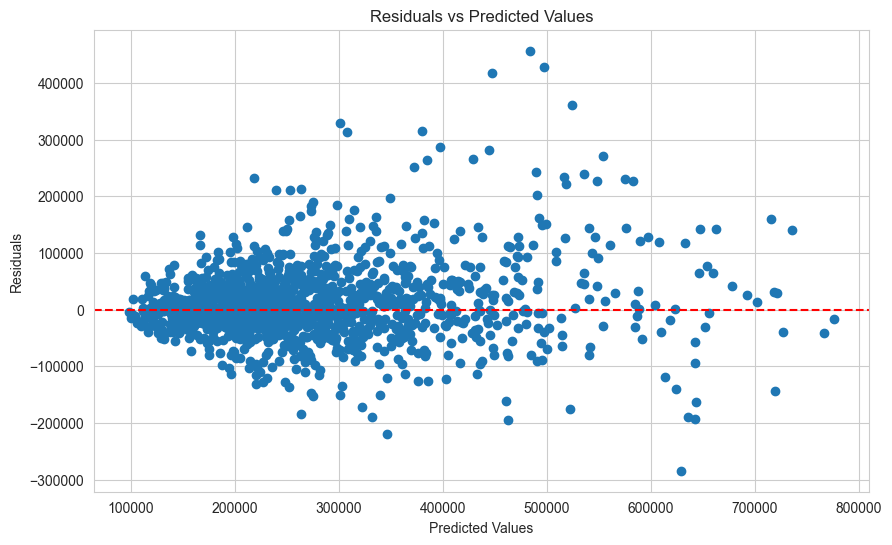

In [24]:
# plot the residuals
residuals = y_test_gbp - y_pred_gbp
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gbp, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

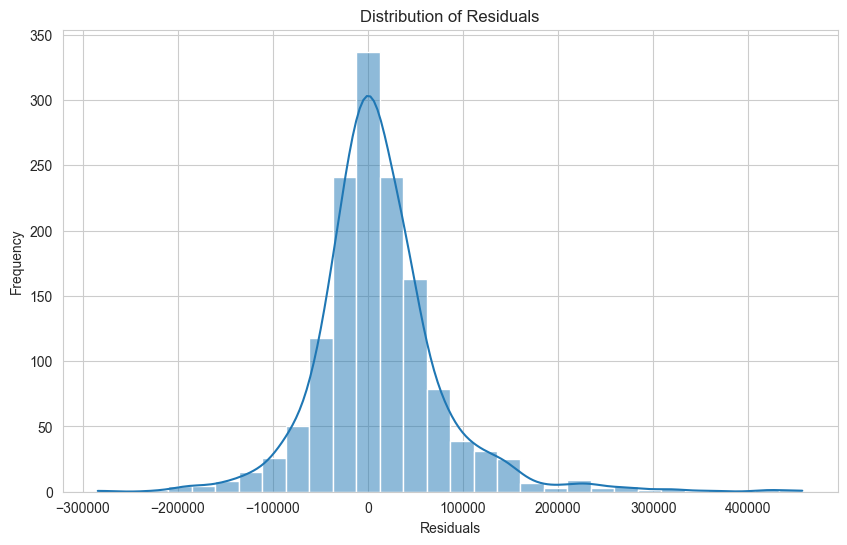

In [25]:
# what is the distribution of the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The following analysis supported by an AI, Claude Sonnet 4.5

SHAP Analysis: Understanding Feature Contributions to House Prices

Calculating SHAP values (this may take a few minutes)...

Analysis complete! Analyzing 16 features.


1. SHAP Summary Plot
--------------------------------------------------------------------------------
This plot shows:
  • Features ranked by importance (top to bottom)
  • Impact direction: Red = higher feature value, Blue = lower feature value
  • Impact magnitude: Distance from center shows strength of effect


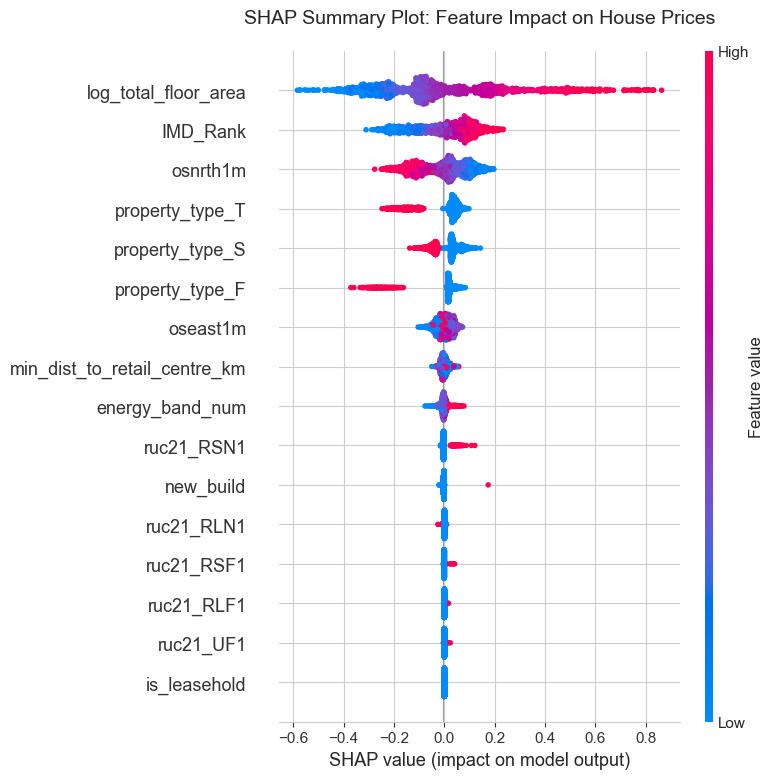


2. SHAP Feature Importance (Mean Absolute Impact)
--------------------------------------------------------------------------------
This shows the average magnitude of each feature's impact on predictions.


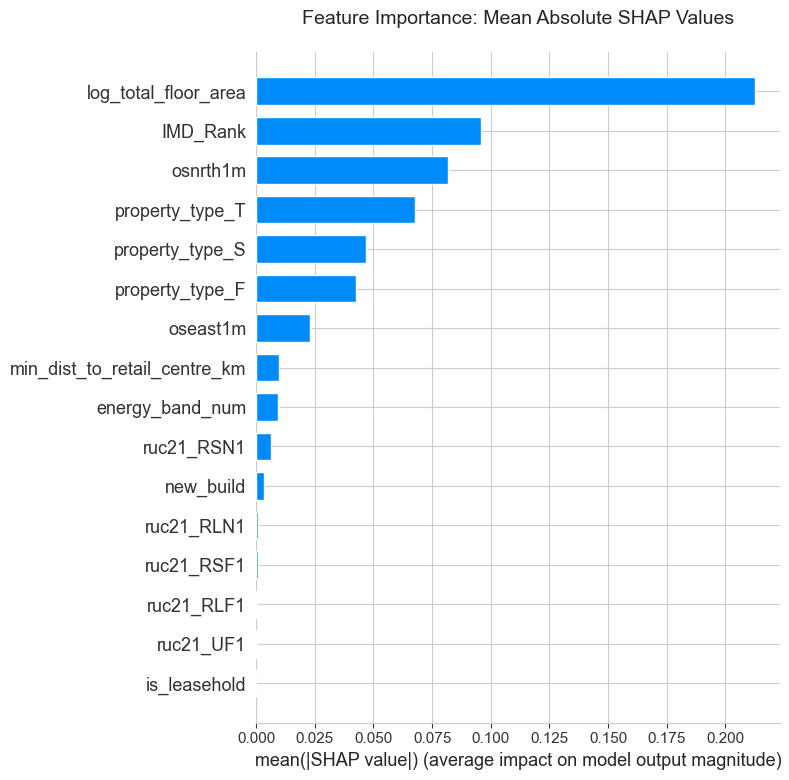


3. SHAP Dependence Plots for Top 6 Features
--------------------------------------------------------------------------------
These plots show how each feature value relates to its impact on price.


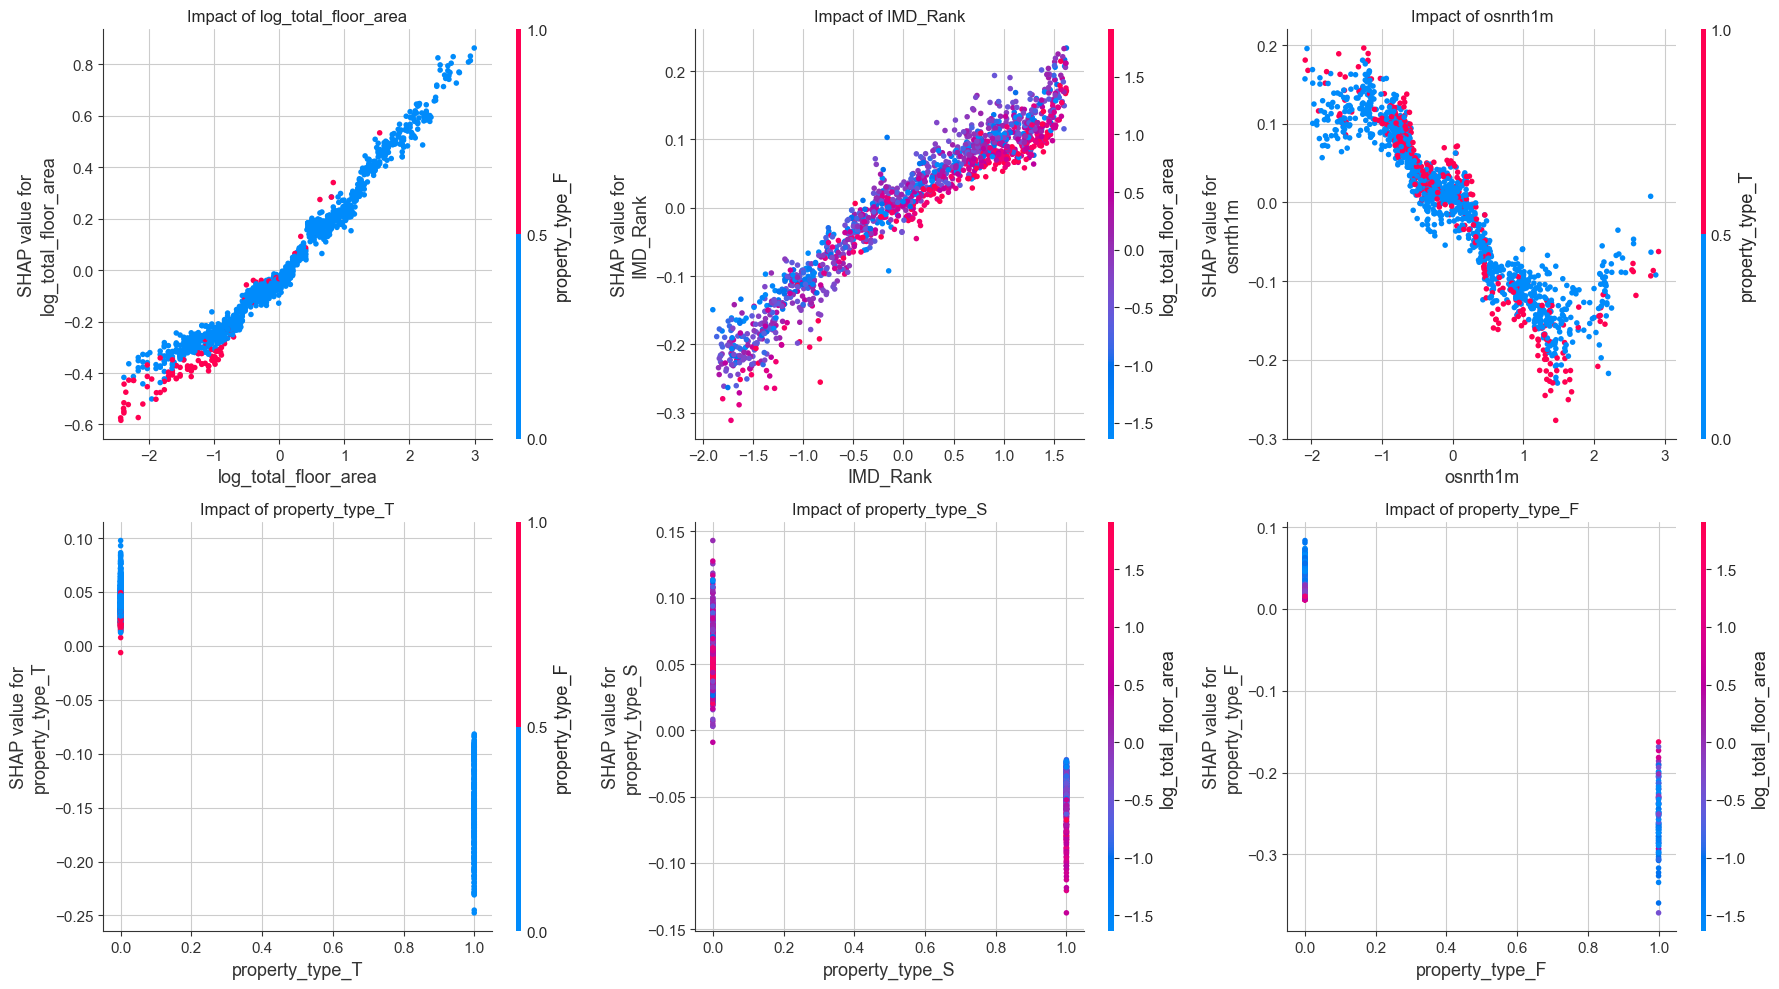


4. Sample Individual Prediction Explanations
--------------------------------------------------------------------------------
These show how features contribute to specific house price predictions.

Lowest Price Property:
  Actual: £78,000
  Predicted: £116,582
  Difference: £38,582


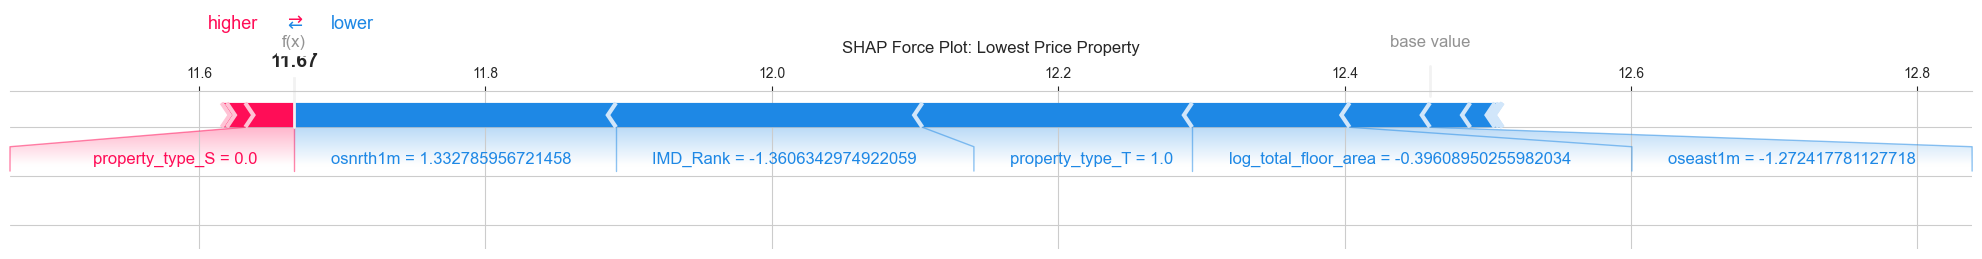


Median Price Property:
  Actual: £253,000
  Predicted: £266,407
  Difference: £13,407


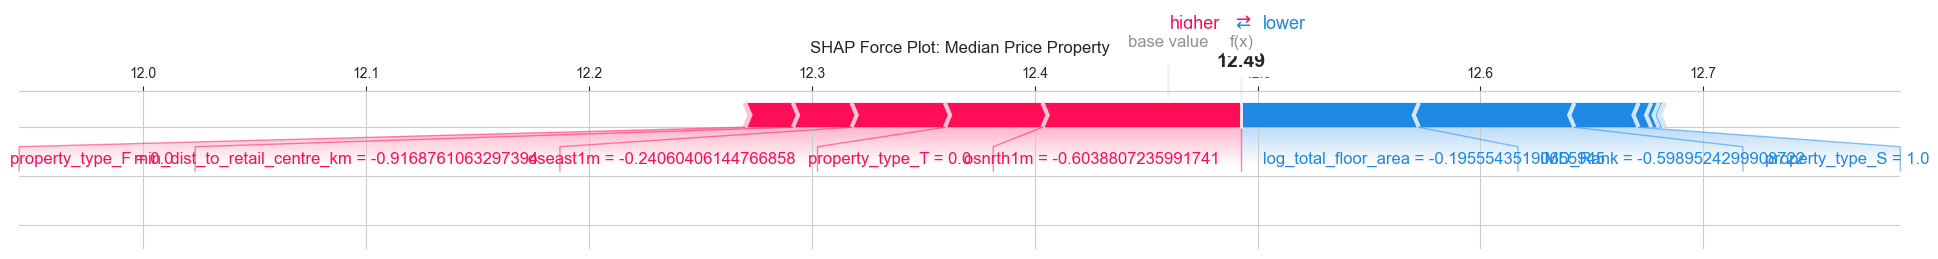


Highest Price Property:
  Actual: £940,000
  Predicted: £483,243
  Difference: £456,757


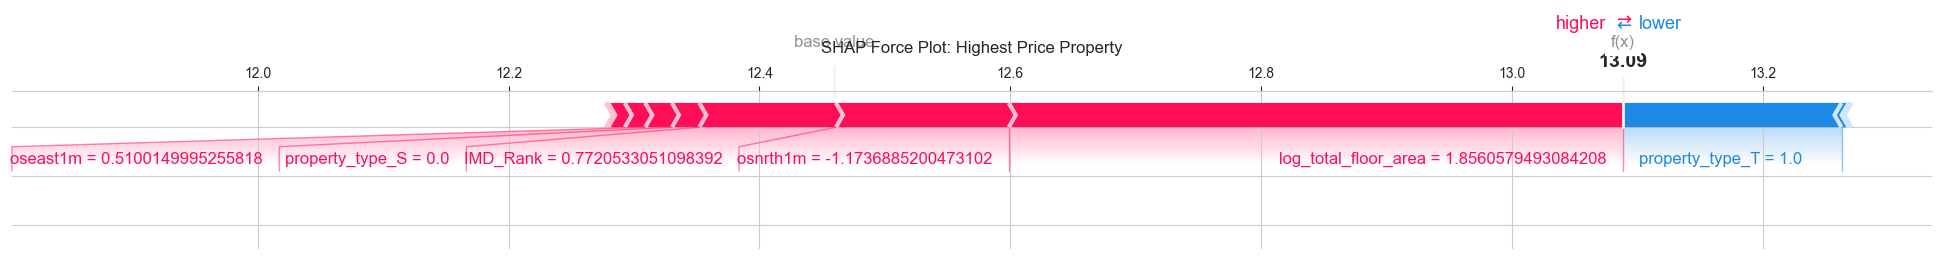


5. Feature Impact Statistics
--------------------------------------------------------------------------------

Top 10 Most Influential Features:
                     Feature  Mean_Abs_Impact  Mean_Impact  Std_Impact Mean_Impact_Direction
        log_total_floor_area         0.212678    -0.009749    0.267808            Negative ↓
                    IMD_Rank         0.095714     0.005444    0.113595            Positive ↑
                    osnrth1m         0.081966    -0.007538    0.097723            Negative ↓
             property_type_T         0.067554    -0.007066    0.085046            Negative ↓
             property_type_S         0.046718     0.010453    0.050196            Positive ↑
             property_type_F         0.042594     0.002072    0.077296            Positive ↑
                    oseast1m         0.023128    -0.000622    0.028238            Negative ↓
min_dist_to_retail_centre_km         0.009654    -0.000742    0.012446            Negative ↓
             ener

In [31]:
# SHAP Analysis for Model Interpretability

import shap
import matplotlib.pyplot as plt

print("=" * 80)
print("SHAP Analysis: Understanding Feature Contributions to House Prices")
print("=" * 80)

# Initialize SHAP explainer
# For tree-based models like XGBoost, we use TreeExplainer
explainer = shap.TreeExplainer(pipeline['model'])

# Transform the test data through the preprocessing pipeline
X_test_transformed = pipeline['pre'].transform(X_test)

# Calculate SHAP values for the test set
print("\nCalculating SHAP values (this may take a few minutes)...")
shap_values = explainer.shap_values(X_test_transformed)

# Get feature names from the preprocessor
feature_names = get_feature_names_from_preprocessor(pipeline['pre'])

print(f"\nAnalysis complete! Analyzing {len(feature_names)} features.")
print("\n" + "=" * 80)

# 1. Summary Plot - Shows feature importance and impact direction
print("\n1. SHAP Summary Plot")
print("-" * 80)
print("This plot shows:")
print("  • Features ranked by importance (top to bottom)")
print("  • Impact direction: Red = higher feature value, Blue = lower feature value")
print("  • Impact magnitude: Distance from center shows strength of effect")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot: Feature Impact on House Prices", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Bar Plot - Shows mean absolute SHAP values (overall feature importance)
print("\n2. SHAP Feature Importance (Mean Absolute Impact)")
print("-" * 80)
print("This shows the average magnitude of each feature's impact on predictions.")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, 
                  plot_type="bar", show=False)
plt.title("Feature Importance: Mean Absolute SHAP Values", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 3. Dependence Plots for Top Features
print("\n3. SHAP Dependence Plots for Top 6 Features")
print("-" * 80)
print("These plots show how each feature value relates to its impact on price.")

# Get top 6 most important features
feature_importance = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(feature_importance)[-6:][::-1]
top_features = [feature_names[i] for i in top_indices]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (feature_idx, feature_name) in enumerate(zip(top_indices, top_features)):
    shap.dependence_plot(
        feature_idx, 
        shap_values, 
        X_test_transformed,
        feature_names=feature_names,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"Impact of {feature_name}", fontsize=12)

plt.tight_layout()
plt.show()

# 4. Force Plot for Individual Predictions
print("\n4. Sample Individual Prediction Explanations")
print("-" * 80)
print("These show how features contribute to specific house price predictions.")

# Show force plots for 3 sample predictions (low, median, high price)
sample_indices = [
    y_test_gbp.idxmin(),  # Lowest price
    y_test_gbp.quantile(0.5),  # Median price (approximate)
    y_test_gbp.idxmax()  # Highest price
]

# Find indices in test set
test_indices = y_test.index
for label, target_value in [("Lowest", y_test_gbp.min()), 
                             ("Median", y_test_gbp.median()), 
                             ("Highest", y_test_gbp.max())]:
    # Find closest match
    idx = (y_test_gbp - target_value).abs().idxmin()
    idx_position = test_indices.get_loc(idx)
    
    actual_price = y_test_gbp.iloc[idx_position]
    predicted_price = y_pred_gbp[idx_position]
    
    print(f"\n{label} Price Property:")
    print(f"  Actual: £{actual_price:,.0f}")
    print(f"  Predicted: £{predicted_price:,.0f}")
    print(f"  Difference: £{abs(actual_price - predicted_price):,.0f}")
    
    # Create force plot
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx_position],
        X_test_transformed[idx_position],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force Plot: {label} Price Property", fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()

# 5. Feature Contribution Summary Statistics
print("\n5. Feature Impact Statistics")
print("-" * 80)

# Create a summary DataFrame
impact_summary = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_Impact': np.abs(shap_values).mean(axis=0),
    'Mean_Impact': shap_values.mean(axis=0),
    'Std_Impact': shap_values.std(axis=0)
})

impact_summary = impact_summary.sort_values('Mean_Abs_Impact', ascending=False)
impact_summary['Mean_Impact_Direction'] = impact_summary['Mean_Impact'].apply(
    lambda x: 'Positive ↑' if x > 0 else 'Negative ↓'
)

print("\nTop 10 Most Influential Features:")
print(impact_summary.head(10).to_string(index=False))

# 6. Interpretation Guide
print("\n" + "=" * 80)
print("INTERPRETATION GUIDE FOR STAKEHOLDERS")
print("=" * 80)

print("""
1. SUMMARY PLOT (First Chart):
   • Features are ranked by importance (most important at top)
   • Each dot represents a property in the test set
   • Color shows feature value: Red = High, Blue = Low
   • Position shows impact: Right = Increases price, Left = Decreases price
   
   Example: If 'log_total_floor_area' is at the top with red dots on the right,
   it means larger floor areas strongly increase predicted prices.

2. FEATURE IMPORTANCE BAR CHART (Second Chart):
   • Shows overall magnitude of each feature's impact
   • Higher bars = more important for price predictions
   • Doesn't show direction (positive/negative), only strength

3. DEPENDENCE PLOTS (Six Charts):
   • Show the relationship between feature values and their impact
   • X-axis: Feature value
   • Y-axis: Impact on predicted price (log scale)
   • Upward slope = higher values increase price
   • Downward slope = higher values decrease price

4. FORCE PLOTS (Individual Examples):
   • Show how features push predictions higher or lower
   • Red arrows = increase price
   • Blue arrows = decrease price
   • Arrow length = magnitude of impact

5. KEY INSIGHTS:
""")

# Print key insights based on top features
for idx, row in impact_summary.head(5).iterrows():
    direction = "increases" if row['Mean_Impact'] > 0 else "decreases"
    print(f"   • {row['Feature']}: {direction} price by £{abs(row['Mean_Impact'])*1000:.0f} on average")

print("\n" + "=" * 80)

In [26]:
# Save in a csv for analysis in Tableau
# merge X_train, X_test, y_train_gbp and y_test_gbp into a single dataframe
to_save = pd.concat([X_train, X_test], axis=0)
predicted_price = pd.concat([
    pd.Series(y_pred_train, name="predicted_price"),
    pd.Series(y_pred_gbp, name="predicted_price")
], axis=0)
to_save = pd.concat([
    to_save.reset_index(drop=True), 
    predicted_price.reset_index(drop=True), 
], axis=1)
# rename columns
to_save = to_save.rename(columns={"y_train_gbp": "actual_price_gbp", "y_test_gbp": "actual_price_gbp", "y_pred_train": "predicted_price_gbp", "y_pred_gbp": "predicted_price_gbp"})


In [27]:
# fix the is_leasehold and is_flat columns to be boolean
to_save['is_leasehold'] = to_save['tenure']=='L'
to_save['is_flat'] = to_save['property_type']=='F'
# is_flat_leasehold
to_save['is_flat_leasehold'] = to_save['is_flat'] & to_save['is_leasehold']

# drop columns with all missing values
to_save = to_save.dropna(axis=1, how='all')

# Save the full set for testing with other models

In [28]:
to_save.to_csv('../data/processed/RandomForestRegressor_set.csv', index=False)

In [29]:
import joblib
joblib.dump(value=pipeline , filename="RandomForestRegressor_model.pkl")

['RandomForestRegressor_model.pkl']

### Conclusions 
Model Evaluation 

* Train Set
R2 Score: 0.95
Mean Absolute Error in GBP: 21,247

* Test Set
R2 Score: 0.77
Mean Absolute Error in GBP: 44,860

- We also note in the plots of Prediction x Actual, the predictions tend to follow the actual value. 
- The residuals distribution is approximately normal, centered around zero, and some outliers in both tails.

---